In [1]:
import findspark
import datetime
findspark.init()
from pyspark import SparkContext
sc = SparkContext("local", "first app")
#print(sc)

In [2]:
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.sql.types import DateType, IntegerType
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

sqlContext = SQLContext(sc)

In [3]:
# Read file for HDFS
orders=sc.textFile("hdfs://quickstart.cloudera:8020/data/orders/orders")
orderdetails=sc.textFile("hdfs://quickstart.cloudera:8020/data/orders/orderdetails")

In [4]:
ordersrdd=orders.map(lambda line: (line.split('|')[0].strip('"'), 
                                   line.split('|')[1].strip('"'),
                                   line.split('|')[2].strip('"'),
                                   line.split('|')[3].strip('"'), 
                                   line.split('|')[4].strip('"'),
                                   line.split('|')[5].strip('"'),
                                   line.split('|')[6].strip('"'))).collect()
#print(ordersrdd[0][1])

In [5]:
orderdetailsrdd=orderdetails.map(lambda line: (line.split('|')[0].strip('"'), 
                                               line.split('|')[1].strip('"'),
                                               line.split('|')[2].strip('"'), 
                                               line.split('|')[3].strip('"'),
                                               line.split('|')[4].strip('"'))).collect()
#print(orderdetailsrdd[0][0])

In [6]:
df_orders=sqlContext.createDataFrame(ordersrdd, schema=['orderNumber', 'orderDate', 
                                                        'requiredDate', 'shippedDate', 
                                                        'status', 'comments', 
                                                        'customerNumber'])
df_orders.show(2)

+-----------+----------+------------+-----------+-------+--------------------+--------------+
|orderNumber| orderDate|requiredDate|shippedDate| status|            comments|customerNumber|
+-----------+----------+------------+-----------+-------+--------------------+--------------+
|      10100|2003-01-06|  2003-01-13| 2003-01-10|Shipped|                  \N|           363|
|      10101|2003-01-09|  2003-01-18| 2003-01-11|Shipped|Check on availabi...|           128|
+-----------+----------+------------+-----------+-------+--------------------+--------------+
only showing top 2 rows



In [7]:
df_orderdetails=sqlContext.createDataFrame(orderdetailsrdd, 
                                           schema=['orderNumber', 'productCode', 
                                                   'quantityOrdered', 'priceEach', 
                                                   'orderLineNumber'])
df_orderdetails.show(2)

+-----------+-----------+---------------+---------+---------------+
|orderNumber|productCode|quantityOrdered|priceEach|orderLineNumber|
+-----------+-----------+---------------+---------+---------------+
|      10100|   S18_1749|             30|   136.00|              3|
|      10100|   S18_2248|             50|    55.09|              2|
+-----------+-----------+---------------+---------+---------------+
only showing top 2 rows



In [8]:
# Join Dataframes
df_join_orders = df_orderdetails.join(df_orders, on='orderNumber')
df_join_orders.show(2)

+-----------+-----------+---------------+---------+---------------+----------+------------+-----------+-------+--------+--------------+
|orderNumber|productCode|quantityOrdered|priceEach|orderLineNumber| orderDate|requiredDate|shippedDate| status|comments|customerNumber|
+-----------+-----------+---------------+---------+---------------+----------+------------+-----------+-------+--------+--------------+
|      10153|   S12_1108|             20|   201.57|             11|2003-09-28|  2003-10-05| 2003-10-03|Shipped|      \N|           141|
|      10153|   S12_3148|             42|   128.42|             12|2003-09-28|  2003-10-05| 2003-10-03|Shipped|      \N|           141|
+-----------+-----------+---------------+---------+---------------+----------+------------+-----------+-------+--------+--------------+
only showing top 2 rows



In [9]:
# Show a sub-set of columns
df_select=df_join_orders.select('customerNumber', 'orderNumber','productCode', 
                                'shippedDate', 'status')
df_select.show(2)

+--------------+-----------+-----------+-----------+-------+
|customerNumber|orderNumber|productCode|shippedDate| status|
+--------------+-----------+-----------+-----------+-------+
|           141|      10153|   S12_1108| 2003-10-03|Shipped|
|           141|      10153|   S12_3148| 2003-10-03|Shipped|
+--------------+-----------+-----------+-----------+-------+
only showing top 2 rows



In [10]:
# Group Columns and aggregate
df_group=df_select.groupBy('shippedDate').agg({'productCode': 'count'})
df_group.show()


+-----------+------------------+
|shippedDate|count(productCode)|
+-----------+------------------+
| 2004-02-06|                 7|
| 2004-10-25|                11|
| 2003-11-20|                33|
| 2004-05-15|                14|
| 2004-08-22|                13|
| 2004-08-23|                28|
| 2003-11-24|                18|
| 2003-06-11|                 4|
| 2003-11-25|                16|
| 2004-01-04|                15|
| 2004-04-10|                17|
| 2003-11-26|                11|
| 2003-03-08|                16|
| 2004-08-26|                13|
| 2003-06-14|                 9|
| 2003-11-27|                16|
| 2003-11-28|                10|
| 2003-09-21|                11|
| 2003-10-20|                12|
| 2003-02-01|                13|
+-----------+------------------+
only showing top 20 rows



In [11]:
# filter results
df_group=df_group.filter(df_group.shippedDate.like('2004-08%'))
df_group.show()

+-----------+------------------+
|shippedDate|count(productCode)|
+-----------+------------------+
| 2004-08-22|                13|
| 2004-08-23|                28|
| 2004-08-26|                13|
| 2004-08-31|                13|
| 2004-08-05|                 1|
| 2004-08-08|                14|
| 2004-08-09|                10|
| 2004-08-15|                 6|
| 2004-08-19|                17|
+-----------+------------------+



In [12]:
# rename columns
df_group_renamed=df_group.select(df_group['shippedDate'], df_group['count(productCode)'].alias('count'))
df_group_renamed.printSchema()
df_group_renamed.show()

root
 |-- shippedDate: string (nullable = true)
 |-- count: long (nullable = false)

+-----------+-----+
|shippedDate|count|
+-----------+-----+
| 2004-08-22|   13|
| 2004-08-23|   28|
| 2004-08-26|   13|
| 2004-08-31|   13|
| 2004-08-05|    1|
| 2004-08-08|   14|
| 2004-08-09|   10|
| 2004-08-15|    6|
| 2004-08-19|   17|
+-----------+-----+



In [13]:
# Convert to Pandas Dataframe
df_group_pndas=df_group_renamed.toPandas()

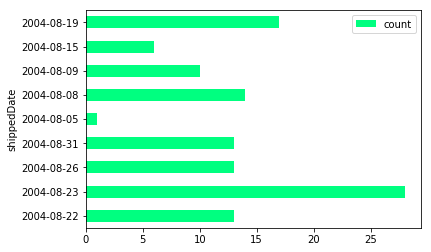

In [14]:
# Plot results
df_group_pndas.plot(kind='barh',x='shippedDate',y='count',colormap='winter_r')

In [15]:
# Filter columns
df_filter=df_select.filter(df_join_orders.status == 'In Process')
df_filter.show(2)

+--------------+-----------+-----------+-----------+----------+
|customerNumber|orderNumber|productCode|shippedDate|    status|
+--------------+-----------+-----------+-----------+----------+
|           282|      10420|   S18_1749|         \N|In Process|
|           282|      10420|   S18_2248|         \N|In Process|
+--------------+-----------+-----------+-----------+----------+
only showing top 2 rows



In [16]:
# Add a new column
df_report = df_filter.withColumn("reportDate", lit(datetime.date.today()))
df_report.show(2)
df_report.printSchema()

+--------------+-----------+-----------+-----------+----------+----------+
|customerNumber|orderNumber|productCode|shippedDate|    status|reportDate|
+--------------+-----------+-----------+-----------+----------+----------+
|           282|      10420|   S18_1749|         \N|In Process|2020-05-25|
|           282|      10420|   S18_2248|         \N|In Process|2020-05-25|
+--------------+-----------+-----------+-----------+----------+----------+
only showing top 2 rows

root
 |-- customerNumber: string (nullable = true)
 |-- orderNumber: string (nullable = true)
 |-- productCode: string (nullable = true)
 |-- shippedDate: string (nullable = true)
 |-- status: string (nullable = true)
 |-- reportDate: date (nullable = false)



In [17]:
# Cast appropriate Datatypes
df_report = df_report.select(df_report.customerNumber.cast(IntegerType()), 
                             df_report.orderNumber.cast(IntegerType()), 
                             'productCode',  'status', 
                             from_unixtime(unix_timestamp('shippedDate', 'yyy-MM-dd')) \
                            .cast(DateType()).alias('shippedDate'))
df_report.show(2)
df_report.printSchema()

+--------------+-----------+-----------+----------+-----------+
|customerNumber|orderNumber|productCode|    status|shippedDate|
+--------------+-----------+-----------+----------+-----------+
|           282|      10420|   S18_1749|In Process|       null|
|           282|      10420|   S18_2248|In Process|       null|
+--------------+-----------+-----------+----------+-----------+
only showing top 2 rows

root
 |-- customerNumber: integer (nullable = true)
 |-- orderNumber: integer (nullable = true)
 |-- productCode: string (nullable = true)
 |-- status: string (nullable = true)
 |-- shippedDate: date (nullable = true)

